# VampNet Masking Study Summary

This notebook summarizes findings from all masking experiments and provides guidelines for choosing masking strategies for different creative applications.

In [1]:
import IPython.display as ipd
import audiotools as at
import matplotlib.pyplot as plt
import numpy as np
import torch
import vampnet
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load interface for demonstrations
interface = vampnet.interface.Interface(
    codec_ckpt="../models/vampnet/codec.pth",
    coarse_ckpt="../models/vampnet/coarse.pth",
    coarse2fine_ckpt="../models/vampnet/c2f.pth",
    wavebeat_ckpt="../models/vampnet/wavebeat.pth",
)
interface.to(device)

/Users/stephen/Documents/Development/MusicHackspace/vampnet_experiments_clean/venv/lib/python3.9/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/Users/stephen/Documents/Development/MusicHackspace/vampnet_experiments_clean/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


/Users/stephen/Documents/Development/MusicHackspace/vampnet_experiments_clean/venv/lib/python3.9/site-packages/audiotools/ml/layers/base.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

Interface(
  (codec): OptimizedModule(
    (_orig_mod): LAC(
      (encoder): Encoder(
        (block): Sequential(
          (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
          (1): EncoderBlock(
            (block): Sequential(
              (0): EncoderLayer(
                (block): Sequential(
                  (0): Snake1d()
                  (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
                  (2): Snake1d()
                  (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
                )
              )
              (1): EncoderLayer(
                (block): Sequential(
                  (0): Snake1d()
                  (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
                  (2): Snake1d()
                  (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
                )
              )
              (2): EncoderLayer(
                (block): Sequential(
                  (

## Summary of Masking Parameters

### 1. Mask Density (Sparse vs Dense)
- **Low density (10-30%)**: Minimal changes, subtle variations
- **Medium density (40-60%)**: Balanced variation while maintaining structure  
- **High density (70-90%)**: Significant creative changes

### 2. Masking Patterns
- **Random**: Smooth, evenly distributed changes
- **Periodic**: Preserves temporal structure, good for rhythm
- **Block**: Creates mashup-like effects with alternating sections
- **Strided**: Regular, predictable variations

### 3. Periodic Prompt Intervals
- **Frequent (2-5 tokens)**: Maximum fidelity, minimal variation
- **Moderate (7-20 tokens)**: Good balance for musical variations
- **Sparse (30-100 tokens)**: Maximum creativity, may lose coherence

### 4. Codebook Masking Depth
- **Depth 0**: All masked - complete regeneration
- **Depth 1-2**: Preserve pitch/rhythm, vary harmony/timbre
- **Depth 3**: Preserve structure, vary details
- **Depth 4+**: Only timbral modifications

In [2]:
# Load example audio for demonstrations
signal = at.AudioSignal("../assets/stargazing.wav")
signal = interface._preprocess(signal)
codes = interface.encode(signal)

# Create output directory
output_dir = Path("outputs/05_summary")
output_dir.mkdir(parents=True, exist_ok=True)

## Recommended Settings for Different Applications

In [3]:
# Application presets
applications = {
    "subtle_variation": {
        "name": "Subtle Variation",
        "desc": "Minor changes while preserving original character",
        "periodic_prompt": 5,
        "upper_codebook_mask": 4,
        "_dropout": 0.0
    },
    "musical_improvisation": {
        "name": "Musical Improvisation", 
        "desc": "Creative variations maintaining musical structure",
        "periodic_prompt": 13,
        "upper_codebook_mask": 2,
        "_dropout": 0.1
    },
    "remix_transform": {
        "name": "Remix/Transform",
        "desc": "Significant changes for remixing",
        "periodic_prompt": 30,
        "upper_codebook_mask": 1,
        "_dropout": 0.2
    },
    "texture_morph": {
        "name": "Texture Morphing",
        "desc": "Change timbre/texture while keeping notes",
        "periodic_prompt": 7,
        "upper_codebook_mask": 3,
        "_dropout": 0.0
    },
    "creative_generation": {
        "name": "Creative Generation",
        "desc": "Maximum creativity with loose connection to original",
        "periodic_prompt": 70,
        "upper_codebook_mask": 0,
        "_dropout": 0.3
    }
}

# Generate examples for each application
print("Generating examples for different applications...\n")

for key, params in applications.items():
    print(f"{params['name']}: {params['desc']}")
    print(f"  Settings: periodic={params['periodic_prompt']}, "
          f"codebook_mask={params['upper_codebook_mask']}, "
          f"dropout={params['_dropout']}")
    
    # Create mask
    mask = interface.build_mask(codes, signal, **{k: v for k, v in params.items() 
                                                  if k not in ['name', 'desc']})
    
    # Generate
    with torch.no_grad():
        output_tokens = interface.vamp(
            codes, mask,
            return_mask=False,
            temperature=1.0,
            typical_filtering=True,
            batch_size=1
        )
    
    # Decode and save
    output_signal = interface.decode(output_tokens)
    output_signal.write(output_dir / f"{key}.wav")
    
    density = mask.float().mean().item()
    print(f"  Mask density: {density:.3f}")
    print(f"  Saved: {key}.wav\n")

Generating examples for different applications...

Subtle Variation: Minor changes while preserving original character
  Settings: periodic=5, codebook_mask=4, dropout=0.0


/Users/stephen/Documents/Development/MusicHackspace/vampnet_experiments_clean/venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


  Mask density: 0.943
  Saved: subtle_variation.wav

Musical Improvisation: Creative variations maintaining musical structure
  Settings: periodic=13, codebook_mask=2, dropout=0.1
  Mask density: 0.990
  Saved: musical_improvisation.wav

Remix/Transform: Significant changes for remixing
  Settings: periodic=30, codebook_mask=1, dropout=0.2
  Mask density: 0.998
  Saved: remix_transform.wav

Texture Morphing: Change timbre/texture while keeping notes
  Settings: periodic=7, codebook_mask=3, dropout=0.0
  Mask density: 0.969
  Saved: texture_morph.wav

Creative Generation: Maximum creativity with loose connection to original
  Settings: periodic=70, codebook_mask=0, dropout=0.3
  Mask density: 1.000
  Saved: creative_generation.wav



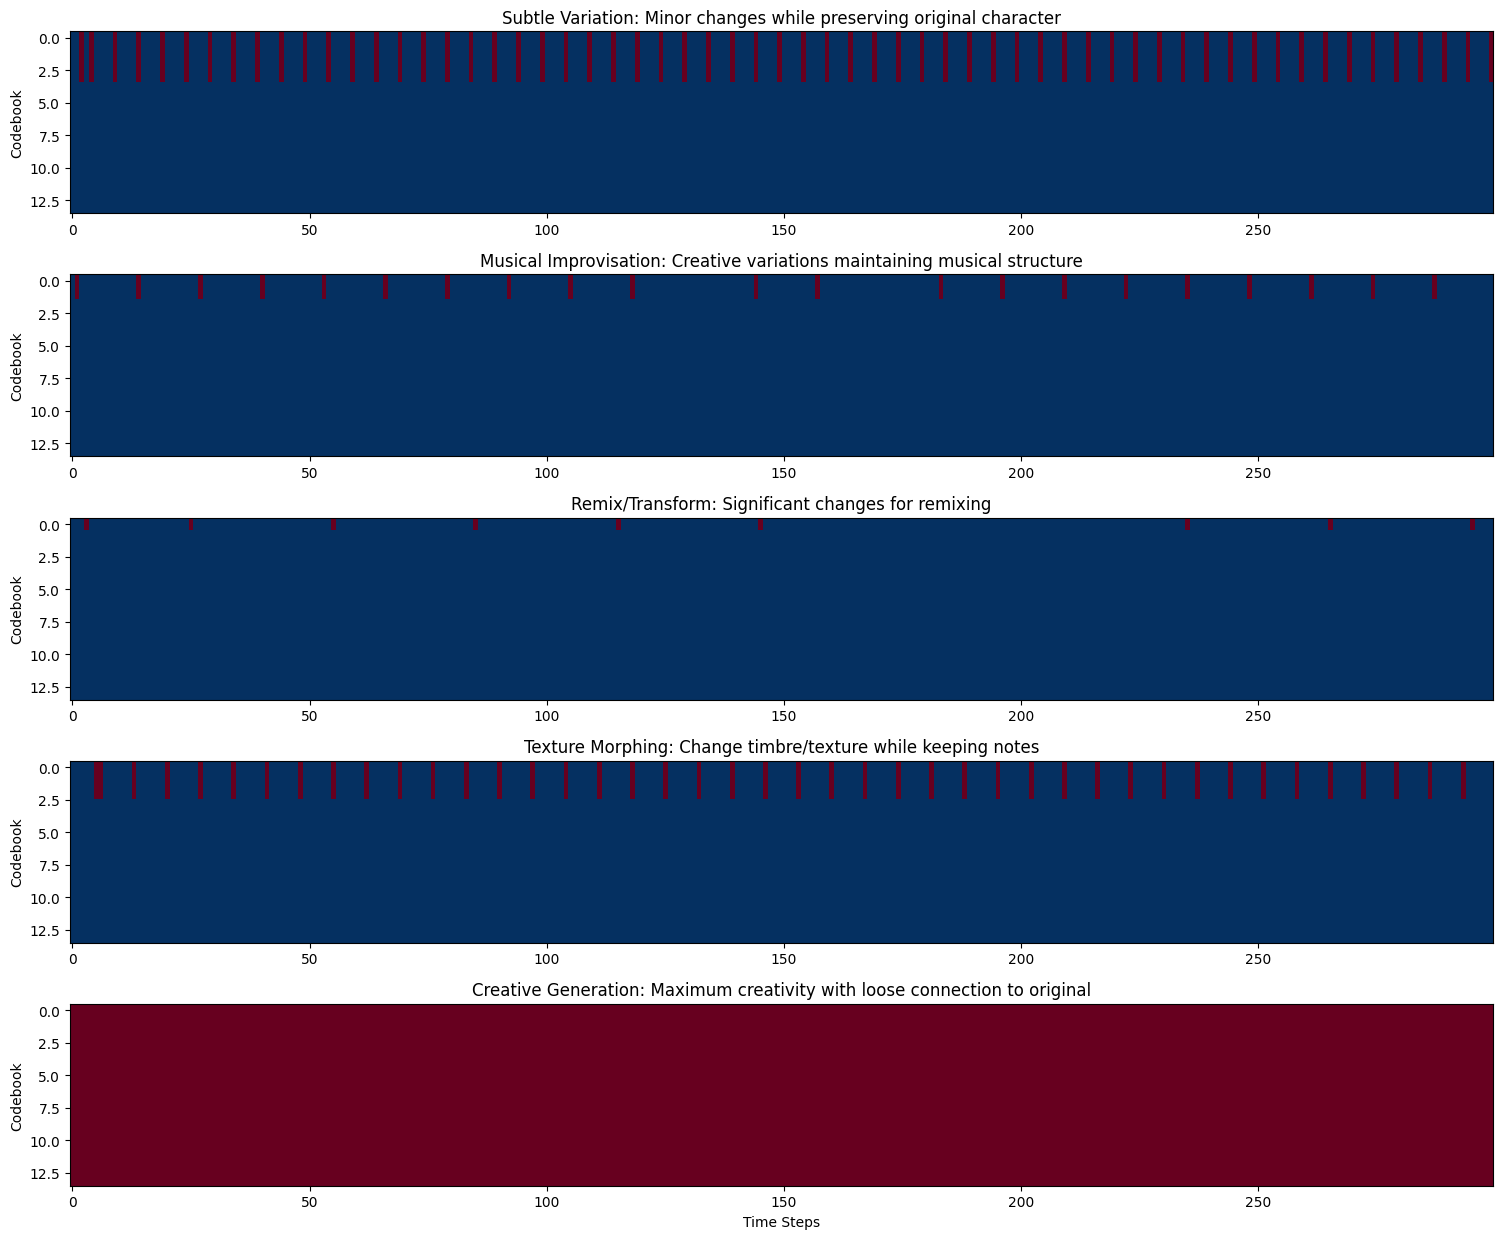

In [4]:
# Visualize mask patterns for each application
fig, axes = plt.subplots(len(applications), 1, figsize=(15, 2.5 * len(applications)))

for idx, (key, params) in enumerate(applications.items()):
    mask = interface.build_mask(codes, signal, **{k: v for k, v in params.items() 
                                                  if k not in ['name', 'desc']})
    
    ax = axes[idx]
    ax.imshow(mask[0, :, :300].cpu().numpy(), aspect='auto', cmap='RdBu')
    ax.set_title(f"{params['name']}: {params['desc']}")
    ax.set_ylabel('Codebook')
    
    if idx == len(applications) - 1:
        ax.set_xlabel('Time Steps')

plt.tight_layout()
plt.savefig(output_dir / "application_masks.png")
plt.show()

## Interactive Masking Guide

Example custom configuration:
Mask density: 0.993


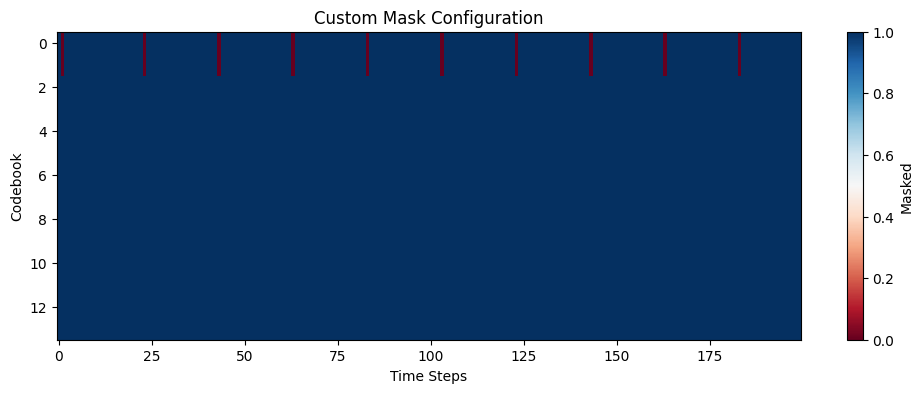

In [5]:
def create_custom_mask(periodic=13, codebook_depth=3, dropout=0.0, pattern="periodic"):
    """Create a custom mask with specified parameters"""
    
    if pattern == "periodic":
        mask = interface.build_mask(
            codes, signal,
            periodic_prompt=periodic,
            upper_codebook_mask=codebook_depth,
            _dropout=dropout
        )
    elif pattern == "random":
        # Custom random mask
        density = 1.0 - (1.0 / periodic)  # Convert periodic to approximate density
        mask = torch.rand(codes.shape) < density
        mask = mask.long().to(codes.device)
        if codebook_depth > 0:
            mask[:, codebook_depth:, :] = 1
    elif pattern == "block":
        # Block pattern
        mask = torch.zeros_like(codes).long()
        block_size = periodic * 5
        for i in range(0, codes.shape[-1], block_size * 2):
            mask[:, :, i:i+block_size] = 1
        if codebook_depth > 0:
            mask[:, codebook_depth:, :] = 1
    
    return mask

# Example: Create a custom configuration
print("Example custom configuration:")
custom_mask = create_custom_mask(periodic=20, codebook_depth=2, dropout=0.15, pattern="periodic")
print(f"Mask density: {custom_mask.float().mean():.3f}")

# Visualize
plt.figure(figsize=(12, 4))
plt.imshow(custom_mask[0, :, :200].cpu().numpy(), aspect='auto', cmap='RdBu')
plt.title('Custom Mask Configuration')
plt.xlabel('Time Steps')
plt.ylabel('Codebook')
plt.colorbar(label='Masked')
plt.show()

## Key Findings and Recommendations

### 1. For Preserving Musical Structure
- Use periodic masking with intervals matching musical beats
- Keep codebook depth at 2-3 to preserve pitch and rhythm
- Use lower mask density (30-50%)

### 2. For Creative Transformation
- Use sparse periodic prompts (30-70 tokens)
- Set codebook depth to 0-1 for maximum variation
- Consider block or strided patterns for structured variation

### 3. For Timbral Modification
- Use high codebook depth (3-4) to preserve notes
- Dense masking on upper codebooks only
- Random or periodic patterns work well

### 4. General Guidelines
- Start conservative and increase masking gradually
- Match periodic intervals to musical tempo when possible
- Combine different mask types for unique effects
- Always use `typical_filtering=True` for better quality

In [6]:
# Save a cheat sheet
cheat_sheet = """
VAMPNET MASKING CHEAT SHEET
==========================

Quick Reference for Common Use Cases:

1. SUBTLE VARIATION
   periodic_prompt=5, upper_codebook_mask=4, dropout=0.0
   → Minor timbral changes, very close to original

2. MUSICAL IMPROVISATION  
   periodic_prompt=13, upper_codebook_mask=2, dropout=0.1
   → Creative melodic/harmonic variations

3. REMIX/TRANSFORM
   periodic_prompt=30, upper_codebook_mask=1, dropout=0.2  
   → Significant transformation for remixing

4. TEXTURE MORPHING
   periodic_prompt=7, upper_codebook_mask=3, dropout=0.0
   → Change instrument timbre, keep notes

5. CREATIVE GENERATION
   periodic_prompt=70, upper_codebook_mask=0, dropout=0.3
   → Maximum creativity, loose connection

Parameter Ranges:
- periodic_prompt: 2-100 (lower = more preserved)
- upper_codebook_mask: 0-4 (higher = more preserved)  
- dropout: 0.0-0.5 (adds randomness)
- temperature: 0.8-1.2 (generation randomness)
"""

with open(output_dir / "masking_cheat_sheet.txt", "w") as f:
    f.write(cheat_sheet)

print("Cheat sheet saved to outputs/05_summary/masking_cheat_sheet.txt")
print(cheat_sheet)

Cheat sheet saved to outputs/05_summary/masking_cheat_sheet.txt

VAMPNET MASKING CHEAT SHEET

Quick Reference for Common Use Cases:

1. SUBTLE VARIATION
   periodic_prompt=5, upper_codebook_mask=4, dropout=0.0
   → Minor timbral changes, very close to original

2. MUSICAL IMPROVISATION  
   periodic_prompt=13, upper_codebook_mask=2, dropout=0.1
   → Creative melodic/harmonic variations

3. REMIX/TRANSFORM
   periodic_prompt=30, upper_codebook_mask=1, dropout=0.2  
   → Significant transformation for remixing

4. TEXTURE MORPHING
   periodic_prompt=7, upper_codebook_mask=3, dropout=0.0
   → Change instrument timbre, keep notes

5. CREATIVE GENERATION
   periodic_prompt=70, upper_codebook_mask=0, dropout=0.3
   → Maximum creativity, loose connection

Parameter Ranges:
- periodic_prompt: 2-100 (lower = more preserved)
- upper_codebook_mask: 0-4 (higher = more preserved)  
- dropout: 0.0-0.5 (adds randomness)
- temperature: 0.8-1.2 (generation randomness)

